In [1]:
import os
import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, HTML

from utils import *

# Tracking a Moving Car

Bayesian methods have a wide range of applications, e.g., in filtering and smoothing of continuous signals. As an example, let us consider uncertain GPS measurement of a car driving on a road. First, we simulate a set of noisy measurements as well as the underlying true trajectory. For now, we consider trajectory simulated with linear transitions.

MPC: 0it [00:00, ?it/s]

Goal


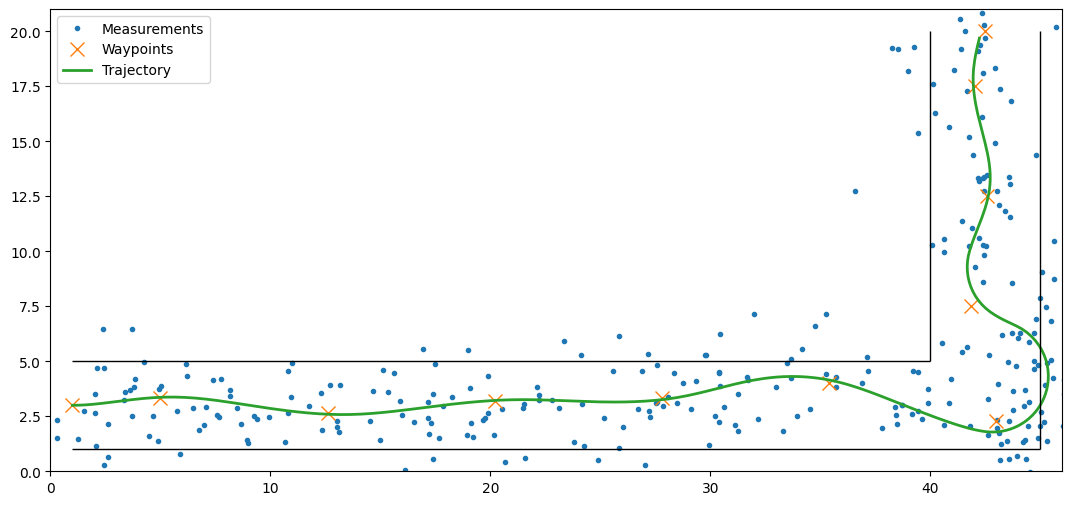

In [2]:
trajectory = MPCTrajectory()
states, measurements = trajectory.get_data()

#np.save("data.npz", {"states": states, "measurements": measurements})

#load data states and measurements
#data = np.load("data.npy", allow_pickle=True).tolist()
#states = data["states"]
#measurements = data["measurements"]

trajectory.plot(states, measurements)

In [3]:
def show_animation(trajectory, gif_path="animations/car_trajectory"):
    def display_animation(gif_path, style='style="max-width:100%;"'):
        display(HTML(f'<img src="{gif_path}" {style}>'))

    if not os.path.exists(gif_path + ".gif"):
        trajectory.animate(filename=gif_path)

    display_animation(gif_path + ".gif")

    plt.close()

show_animation(trajectory)

# Kalman Filtering

As a model of the trajectory of the moving car, we consider a markovian approach. That is, a state-space model of unobserved states approximated using observed measurements. Markovian models have the property that all relevant infomation about the next state is contained in the current state, i.e., all information from previous states can be disregarded. If we denote the state a time $k$ as $x_k$ and the corresponding measurement as $y_k$, the markovian model can be formulated as 

$$
x_k \sim p(x_k | x_{k-1}),
$$

$$
y_k \sim p(y_k | x_{k}).
$$

The task at hand is to estimate the next state based on all knowledge of previous measurement: We cant to find the marginal posterior

$$
p(x_k | y_{1:k}).
$$

Now, the closed form solution to the recursive Bayesian filtering equations can be used to describe a linear system descriping the moving car:

$$
\begin{aligned}
\mathbf{x}_k & =\mathbf{A}_{k-1} \mathbf{x}_{k-1}+\mathbf{q}_{k-1}, \\
\mathbf{y}_k & =\mathbf{H}_k \mathbf{x}_k+\mathbf{r}_k,
\end{aligned}
$$

where $\mathbf{A}$ is the trasition function between states, $\mathbf{H}$ is the trasition between measurement, and $\mathbf{q}$ and $\mathbf{r}$ are the state and measurement noise, respectively.

If we assume that the dynamic and the measurement models are Gaussian, i.e.,

$$
\begin{aligned}
p\left(\mathbf{x}_k \mid \mathbf{x}_{k-1}\right) & =\mathrm{N}\left(\mathbf{x}_k \mid \mathbf{A}_{k-1} \mathbf{x}_{k-1}, \mathbf{Q}_{k-1}\right), \\
p\left(\mathbf{y}_k \mid \mathbf{x}_k\right) & =\mathrm{N}\left(\mathbf{y}_k \mid \mathbf{H}_k \mathbf{x}_k, \mathbf{R}_k\right),
\end{aligned}
$$

evaluating the closed form of the posterior results in a Gaussian:

$$
p\left(\mathbf{x}_k \mid \mathbf{y}_{1: k}\right)=\mathrm{N}\left(\mathbf{x}_k \mid \mathbf{m}_k, \mathbf{P}_k\right),
$$

The iterative process of estimating a new state involves a prediction step

$$
\begin{aligned}
\mathbf{m}_k^{-} & =\mathbf{A}_{k-1} \mathbf{m}_{k-1} \\
\mathbf{P}_k^{-} & =\mathbf{A}_{k-1} \mathbf{P}_{k-1} \mathbf{A}_{k-1}^{\top}+\mathbf{Q}_{k-1},
\end{aligned}
$$

and an update step

$$
\begin{aligned}
\mathbf{v}_k & =\mathbf{y}_k-\mathbf{H}_k \mathbf{m}_k^{-}, \\
\mathbf{S}_k & =\mathbf{H}_k \mathbf{P}_k^{-} \mathbf{H}_k^{\top}+\mathbf{R}_k, \\
\mathbf{K}_k & =\mathbf{P}_k^{-} \mathbf{H}_k^{\top} \mathbf{S}_k^{-1}, \\
\mathbf{m}_k & =\mathbf{m}_k^{-}+\mathbf{K}_k \mathbf{v}_k, \\
\mathbf{P}_k & =\mathbf{P}_k^{-}-\mathbf{K}_k \mathbf{S}_k \mathbf{K}_k^{\top}.
\end{aligned}
$$

This process of estimating the next step is known as the $\textit{Kalman filter}$.

Returning to the car example, we illustrate the Kalman filter in action. Here, the dynamics of the system is described by

$$ A =
\left[\begin{array}{llll}
1 & 0 & 0.1 & 0 \\
0 & 1 & 0 & 0.1 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right],
$$

and the measurement as 

$$ H =
\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{array}\right],
$$

and the noise is Gaussian. We then apply Kalman filter to this system.

In [4]:
def visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant=""):

        fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
        for k in range(2):
                ax[k].plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
                ax[k].plot(states[:, 0], states[:, 1], '--', color='r', label="True trajectory")
                ax[k].plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")

        plot_trajectory(ax[0], state_estimates, cov_estimates, label=f"{variant} Kalman Filter x")
        plot_trajectory(ax[1], state_estimates_smoothed, cov_estimates_smoothed, label=f"{variant} RTS Smoother")

        # Show the MSE on the plot in upper right corner
        ax[0].text(1.00, 1.05, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates[:, :2])**2)),
                horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
        ax[1].text(1.00, 1.05, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates_smoothed[:, :2])**2)),
                horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)
        
        for k in range(2):
                ax[k].hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
                ax[k].hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
                ax[k].vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
                ax[k].vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

                ax[k].set_xlabel('x')
                ax[k].set_ylabel('y')

                ax[k].legend()

        ax[0].set_title(f"{variant} Kalman Filter")
        ax[1].set_title(f"{variant} RTS Smoother")

        plt.tight_layout()
        plt.show()

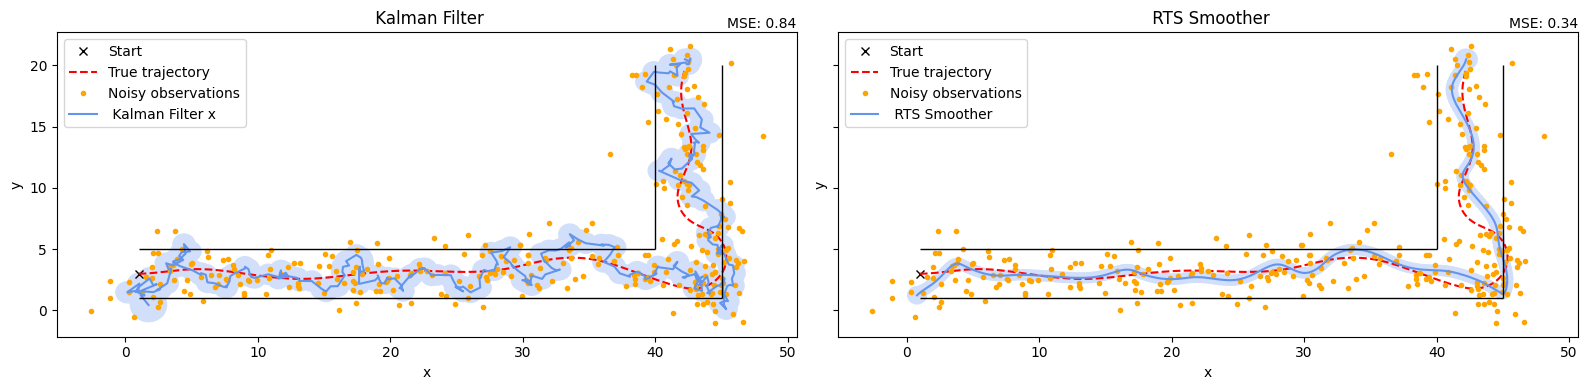

In [5]:
system = CarTrajectoryLinear()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed)

In [6]:
def show_filter_animation(animation, gif_path):
    if not os.path.exists(gif_path + ".gif"):
        animation.animate()

    # Clear the redundant plot
    animation.ax.clear()

    # Display the animation without any additional plot
    display(HTML(f'<img src="{gif_path}.gif">'))

    plt.close()

In [7]:
kalman_animation_path = "animations/kalman_filter"
kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=kalman_animation_path)

show_filter_animation(kalman_animation, kalman_animation_path)

  0%|          | 0/608 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.


The Kalman filter is an incredible effective tool for filtering linear measurents to approximate the hidden states. What happens, then, if the system is not linear? The trasition functions are then drecribed by more general, non-linear functions, that is, 

$$
\begin{aligned}
\mathbf{x}_k & =\mathbf{f}\left(\mathbf{x}_{k-1}\right)+\mathbf{q}_{k-1}, \\
\mathbf{y}_k & =\mathbf{h}\left(\mathbf{x}_k\right)+\mathbf{r}_k.
\end{aligned}
$$

The main issue is that non-linear transformation of Gaussains are not gaussian! Of course, on approach is to assume that the marginal posterior distribution are reasonably Gaussian such that it can be approximated by

$$
p\left(\mathbf{x}_k \mid \mathbf{y}_{1: k}\right) \simeq \mathrm{N}\left(\mathbf{x}_k \mid \mathbf{m}_k, \mathbf{P}_k\right).
$$

In Extendted Kalman Filtering (EKF), we use Taylor series to approximate the non-linearities. This means that we must know the exact dynamics of the system.

The prediction step becomes

$$
\begin{aligned}
\mathbf{m}_k^{-} & =\mathbf{f}\left(\mathbf{m}_{k-1}\right), \\
\mathbf{P}_k^{-} & =\mathbf{F}_{\mathbf{x}}\left(\mathbf{m}_{k-1}\right) \mathbf{P}_{k-1} \mathbf{F}_{\mathbf{x}}^{\top}\left(\mathbf{m}_{k-1}\right)+\mathbf{Q}_{k-1},
\end{aligned}
$$

and the update step becomes

$$
\begin{aligned}
\mathbf{v}_k & =\mathbf{y}_k-\mathbf{h}\left(\mathbf{m}_k^{-}\right), \\
\mathbf{S}_k & =\mathbf{H}_{\mathbf{x}}\left(\mathbf{m}_k^{-}\right) \mathbf{P}_k^{-} \mathbf{H}_{\mathbf{x}}^{\top}\left(\mathbf{m}_k^{-}\right)+\mathbf{R}_k, \\
\mathbf{K}_k & =\mathbf{P}_k^{-} \mathbf{H}_{\mathbf{x}}^{\top}\left(\mathbf{m}_k^{-}\right) \mathbf{S}_k^{-1}, \\
\mathbf{m}_k & =\mathbf{m}_k^{-}+\mathbf{K}_k \mathbf{v}_k, \\
\mathbf{P}_k & =\mathbf{P}_k^{-}-\mathbf{K}_k \mathbf{S}_k \mathbf{K}_k^{\top} .
\end{aligned}
$$


In essense, this means using the Jacobian of the transition function and the measurement model matrix, respectively.

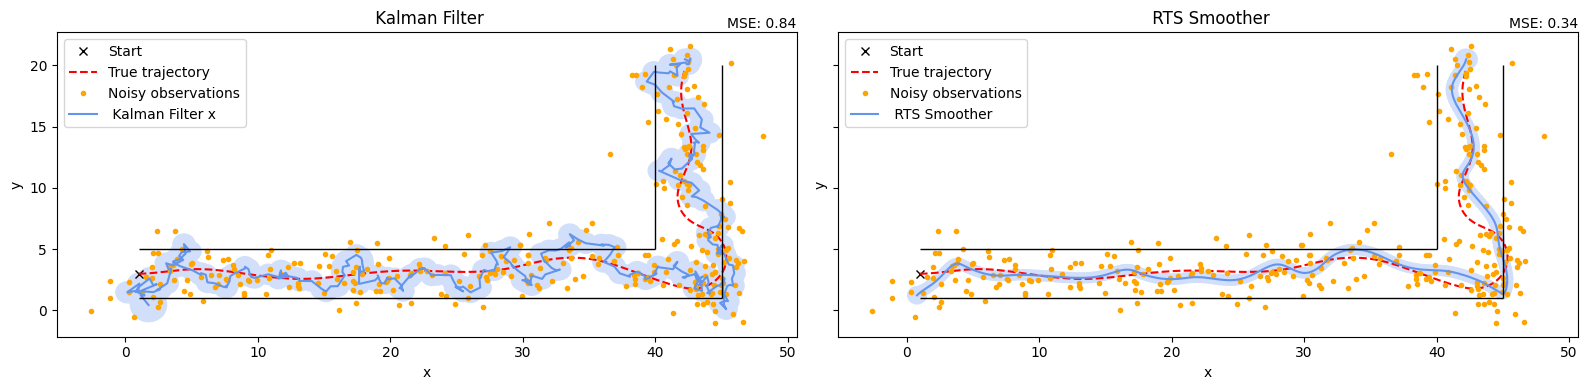

In [8]:
system = CarTrajectoryNonLinear()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed)

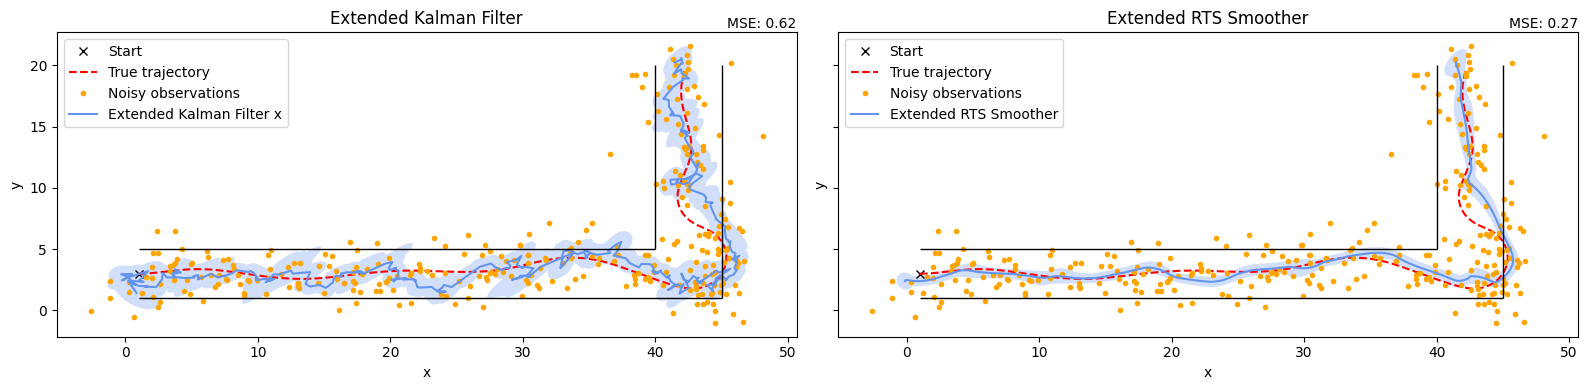

In [9]:
extendted_kalman_filter = EKF(system.f, system.F_jacobian, system.h, system.H_jacobian, system.Q, system.R)
state_estimates, cov_estimates = extendted_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extendted_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Extended")

In [10]:
extended_kalman_animation_path = "animations/extended_kalman_filter"
extended_kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=extended_kalman_animation_path)

show_filter_animation(extended_kalman_animation, extended_kalman_animation_path)

  0%|          | 0/608 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.


Unscented Kalman Filtering (UKF) uses the unscented transformation and is used for approximating distributations of the same form as EKF. Prediction:

- Prediction:


1. Form the sigma points:
$$
\begin{aligned}
\mathcal{X}_{k-1}^{(0)} & =\mathbf{m}_{k-1}, \\
\mathcal{X}_{k-1}^{(i)} & =\mathbf{m}_{k-1}+\sqrt{n+\lambda}\left[\sqrt{\mathbf{P}_{k-1}}\right]_i, \\
\mathcal{X}_{k-1}^{(i+n)} & =\mathbf{m}_{k-1}-\sqrt{n+\lambda}\left[\sqrt{\mathbf{P}_{k-1}}\right]_i, \quad i=1, \ldots, n,
\end{aligned}
$$



2. Propagate the sigma points through the dynamic model:
$$
\hat{\mathcal{X}}_k^{(i)}=\mathbf{f}\left(\mathcal{X}_{k-1}^{(i)}\right), \quad i=0, \ldots, 2 n .
$$


3. Compute the predicted mean $\mathbf{m}_k^{-}$ and the predicted covariance $\mathbf{P}_k^{-}$:
$$
\begin{aligned}
& \mathbf{m}_k^{-}=\sum_{i=0}^{2 n} W_i^{(\mathrm{m})} \hat{\mathcal{X}}_k^{(i)}, \\
& \mathbf{P}_k^{-}=\sum_{i=0}^{2 n} W_i^{(\mathrm{c})}\left(\hat{\mathcal{X}}_k^{(i)}-\mathbf{m}_k^{-}\right)\left(\hat{\mathcal{X}}_k^{(i)}-\mathbf{m}_k^{-}\right)^{\top}+\mathbf{Q}_{k-1},
\end{aligned}
$$
where the weights $W_i^{(\mathrm{m})}$ and $W_i^{(\mathrm{c})}$ were defined in Equation (5.77).

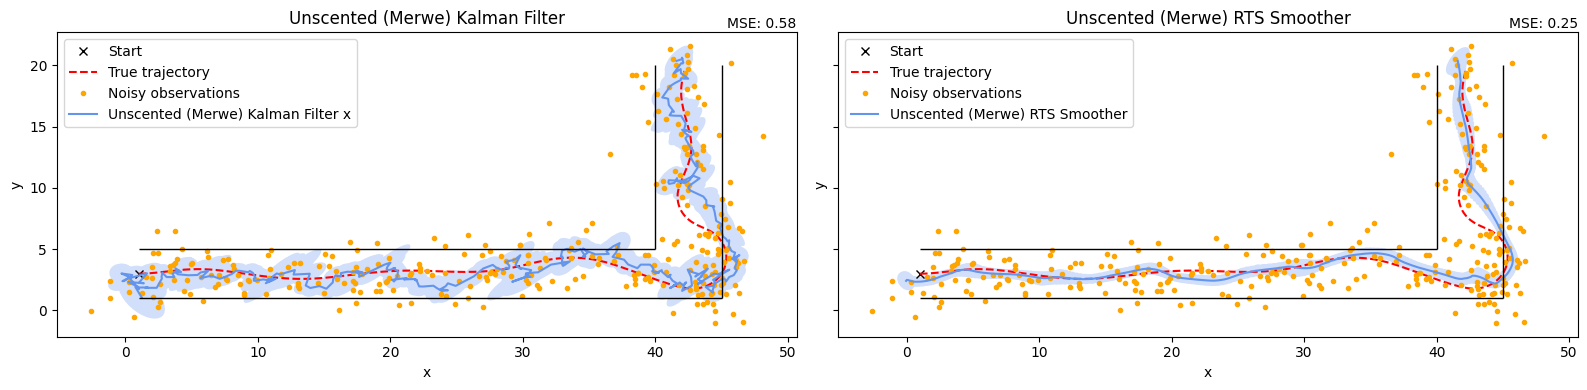

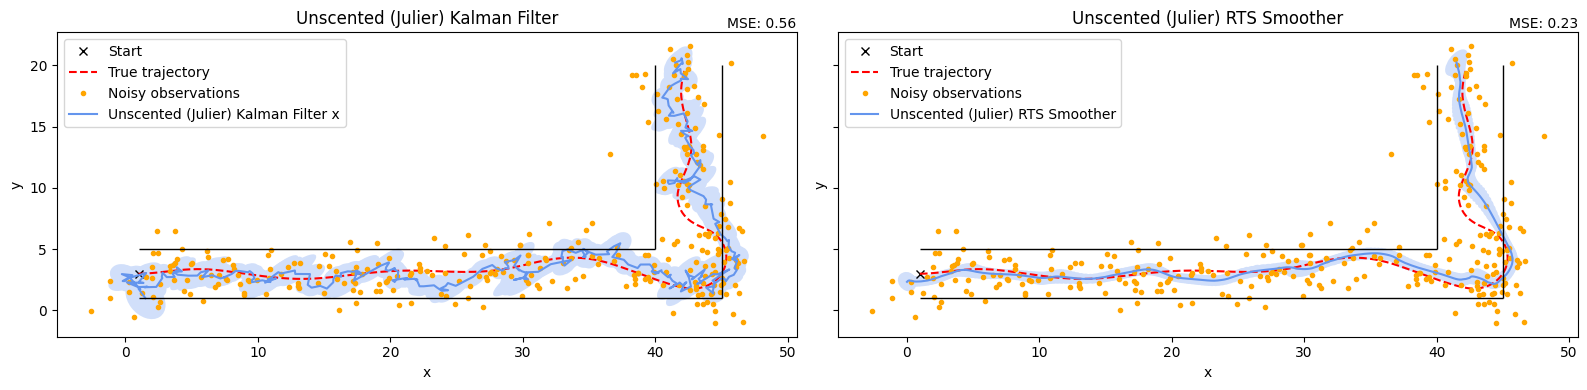

In [11]:
alpha = .5
beta = 2
kappa = 0

unscented_kalman_filter = UKF(system.f, system.h, system.Q, system.R, alpha=alpha, beta=beta, kappa=kappa, method='merwe')
state_estimates, cov_estimates = unscented_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = unscented_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Unscented (Merwe)")

unscented_kalman_filter = UKF(system.f, system.h, system.Q, system.R, alpha=alpha, beta=beta, kappa=kappa, method='julier')
state_estimates, cov_estimates = unscented_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = unscented_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Unscented (Julier)")

In [12]:
unscented_kalman_animation_path = "animations/unscented_kalman_filter"
unscented_kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=unscented_kalman_animation_path)

show_filter_animation(unscented_kalman_animation, unscented_kalman_animation_path)

  0%|          | 0/608 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.
